In [83]:
#!pip install nb_black  --> I don't know what these two does, so I just comment them.
# AM: It formats the code nicely according to best practice - https://github.com/dnanhkhoa/nb_black

<IPython.core.display.Javascript object>

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# QRM Second Assignment

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
import scipy as sc
import glob
import matplotlib.pyplot as plt
import os
from datetime import datetime

1. Assignment says we can disregard exchange rates
2. Propose not to use the bond since it's different format and different way of calculating returns, so creates more issues. I added Tesla (TSLA), Lufthansa (LHA), Adidas (ADS) and Heineken (HEIA)
3. From student-t distribution I see more outliers, we need to discover and treat them

## Exploratory Data Analysis

In [2]:
"""Import data"""
BTC = pd.read_csv("01_Data/BTCUSD.csv",)
DBC = pd.read_csv("01_Data/DBC.csv")
GSPC = pd.read_csv("01_Data/GSPC.csv")
N225 = pd.read_csv("01_Data/N225.csv")

"""New Stocks - chose ones that are not in S&P 500 so there is no overlap"""
#Tesla
TSLA = pd.read_csv("01_Data/TSLA.csv")
#Lufthansa (De)
LHA = pd.read_csv("01_Data/LHA.csv")
#Adidas (De)
ADS = pd.read_csv("01_Data/ADS.csv")
#Heineken
HEIA = pd.read_csv("01_Data/HEIA.csv")


"""Check format of the datasets - same column format, different length"""
#print(BTC.shape)
#print(DBC.shape)
#print(GSPC.shape)
#print(N225.shape)
#print(TSLA.shape)
#print(LHA.shape)
#print(ADS.shape)
#print(HEIA.shape)

"""Check if there is null or empty input for any of the datasets."""
#print(N225.isnull().sum())
#print(BTC.isnull().sum())
#print(DBC.isnull().sum())
#print(GSPC.isnull().sum())
#print(ADS.isnull().sum())
#print(LHA.isnull().sum())
#print(HEIA.isnull().sum())
#print(TSLA.isnull().sum())

"""N225 has 20 missing values"""
# missing_N225 = N225[N225.isna().any(axis=1)]['Date']
# print(len(N225[N225.isna().any(axis=1)]))
# print(missing_N225)

'N225 has 20 missing values'

**EDA shows 1 issue:**

1. N225 contains 20 missing values, which need to be dropped

In [3]:
""" Drop the rows which contains missing value in N225"""
N225_drop = N225.dropna(axis=0)
N225_drop = N225_drop.reset_index(drop=True)
print(len(N225_drop))
# N225_drop.isnull().sum()

2205


## Data Processing

### 1. Merge data

In [4]:
s1 = set(GSPC["Date"])
s2 = set(DBC["Date"])
s3 = set(N225_drop["Date"])
s4 = set(BTC["Date"])
s5 = set(TSLA["Date"])
s6 = set(LHA["Date"])
s7 = set(ADS["Date"])
s8 = set(HEIA["Date"])

d = [
    x for x in s3 if x in s1 and x in s2 and x in s4 and x in s5 and x in s6 and x in s7 and x in s8
]

asset = [s1, s2, s3, s4, s5, s6, s7, s8]

intersec = s3.intersection(s1, s2, s4, s5, s6, s7, s8)
print(len(intersec))
print(len(d))
set(d) == set(intersec)

print("The dates exist in all five dataset: 2096 trading days")

2096
2096
The dates exist in all five dataset: 2096 trading days


In [5]:
"""  Create new dataframes, keep only the overlapping date-related data"""

new = []
asset = [BTC, DBC, GSPC, N225_drop, TSLA, LHA, ADS, HEIA]
for item in asset:
    miss = []
    for i in item["Date"]:
        if i not in intersec:
            miss = miss + item.index[item["Date"] == i].tolist()
    item = item.drop(miss)
    item = item.reset_index(drop=True)
    new.append(item)

In [6]:
""" Assign the dataframe """

BTC_new = new[0]
DBC_new = new[1]
GSPC_new = new[2]
N225_new = new[3]
TSLA_new = new[4]
LHA_new = new[5]
ADS_new = new[6]
HEIA_new = new[7]

asset = [BTC_new, DBC_new, GSPC_new, N225_new, TSLA_new, LHA_new, ADS_new, HEIA_new]

for i in asset:
    print(i.shape)
    print(i.isnull().sum())

(2096, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2096, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2096, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2096, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2096, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2096, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2096, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2096, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volu

In [7]:
""" Create new dataframe containing only the same dates related information  """

# asset_price , asset_adj_price , return

asset = [BTC_new, DBC_new, GSPC_new, N225_new, TSLA_new, LHA_new, ADS_new, HEIA_new]
asset_name = ["BTC", "DBC", "GSPC", "N225", "TSLA", "LHA", "ADS", "HEIA"]

for i in range(len(asset)):
    """Rename Price column"""
    asset[i].rename(columns={"Adj Close": "Price_" + asset_name[i]}, inplace=True)
    """Create lags for all assets"""
    asset[i]["Price_" + asset_name[i] + "_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    """Calculate individual asset returns"""
    # Stocks - log return
    asset[i][asset_name[i] + "_return"] = np.log(
        asset[i]["Price_" + asset_name[i]]
        / asset[i]["Price_" + asset_name[i] + "_lag"]
    )


print(HEIA_new)

            Date       Open       High        Low      Close  Price_HEIA  \
0     2011-03-31  38.474998  38.794998  38.360001  38.555000   32.077000   
1     2011-04-01  38.794998  38.990002  38.580002  38.814999   32.293316   
2     2011-04-04  38.790001  39.165001  38.509998  39.020000   32.463871   
3     2011-04-05  39.160000  39.509998  39.075001  39.455002   32.825787   
4     2011-04-06  39.560001  39.639999  39.080002  39.099998   32.530422   
...          ...        ...        ...        ...        ...         ...   
2091  2020-03-24  72.419998  74.400002  68.900002  71.440002   70.453049   
2092  2020-03-25  71.980003  74.300003  70.980003  73.000000   71.991501   
2093  2020-03-26  71.800003  73.940002  71.419998  73.940002   72.918510   
2094  2020-03-27  71.720001  73.339996  71.339996  72.139999   71.143379   
2095  2020-03-30  72.500000  73.339996  70.199997  73.019997   72.011215   

       Volume  Price_HEIA_lag  HEIA_return  
0     1310333             NaN          NaN

In [8]:
# Keep only relevant columns

result = []
for i in range(len(asset)):
    print(asset_name[i])
    asset[i] = asset[i][
        [
            "Date",
            "Price_" + asset_name[i],
            "Price_" + asset_name[i] + "_lag",
            asset_name[i] + "_return",
        ]
    ]
    result.append(asset[i])

BTC
DBC
GSPC
N225
TSLA
LHA
ADS
HEIA


In [9]:
# Check the shape
BTC_new = result[0]
DBC_new = result[1]
GSPC_new = result[2]
N225_new = result[3]
TSLA_new = result[4]
LHA_new = result[5]
ADS_new = result[6]
HEIA_new = result[7]

asset = [BTC_new,DBC_new,GSPC_new,N225_new,TSLA_new,LHA_new, ADS_new, HEIA_new]


for i in asset:
    print(i.shape)


(2096, 4)
(2096, 4)
(2096, 4)
(2096, 4)
(2096, 4)
(2096, 4)
(2096, 4)
(2096, 4)


In [10]:
"""Add FX_YEN and FX_EUR to the list and merge data """
data = pd.concat(asset, axis=1)
data = data.loc[:,~data.columns.duplicated()]
data.head()

,Date,Price_BTC,Price_BTC_lag,BTC_return,Price_DBC,Price_DBC_lag,DBC_return,Price_GSPC,Price_GSPC_lag,GSPC_return,...,TSLA_return,Price_LHA,Price_LHA_lag,LHA_return,Price_ADS,Price_ADS_lag,ADS_return,Price_HEIA,Price_HEIA_lag,HEIA_return
0,2011-03-31,0.7846,NaN,NaN,29.643923,NaN,NaN,1325.829956,NaN,NaN,...,NaN,12.251600,NaN,NaN,38.101170,NaN,NaN,32.077000,NaN,NaN
1,2011-04-01,0.7741,0.7846,-0.013473,29.847960,29.643923,0.006859,1332.410034,1325.829956,0.004951,...,-0.040072,12.288465,12.251600,0.003004,38.264011,38.101170,0.004265,32.293316,32.077000,0.006721
2,2011-04-04,0.6800,0.7741,-0.129608,30.120012,29.847960,0.009073,1332.869995,1332.410034,0.000345,...,-0.031628,12.190158,12.288465,-0.008032,38.294014,38.264011,0.000784,32.463871,32.293316,0.005268
3,2011-04-05,0.7100,0.6800,0.043172,30.149160,30.120012,0.000967,1332.630005,1332.869995,-0.000180,...,0.033127,12.100043,12.190158,-0.007420,38.988239,38.294014,0.017966,32.825787,32.463871,0.011087
4,2011-04-06,0.7400,0.7100,0.041385,30.236607,30.149160,0.002896,1335.540039,1332.630005,0.002181,...,-0.007896,12.239309,12.100043,0.011444,39.116795,38.988239,0.003292,32.530422,32.825787,-0.009039


### 2.1 Calculate portfolio returns

In [11]:
"""Assume equal weight (0.125) for the 8 assets and calculate portfolio returns"""

data["portfolio_return"] = (
    0.125 * data["BTC_return"]
    + 0.125 * data["DBC_return"]
    + 0.125 * data["GSPC_return"]
    + 0.125 * data["N225_return"]
    + 0.125 * data["TSLA_return"]
    + 0.125 * data["LHA_return"]
    + 0.125 * data["ADS_return"]
    + 0.125 * data["HEIA_return"]
)
data.tail()

,Date,Price_BTC,Price_BTC_lag,BTC_return,Price_DBC,Price_DBC_lag,DBC_return,Price_GSPC,Price_GSPC_lag,GSPC_return,...,Price_LHA,Price_LHA_lag,LHA_return,Price_ADS,Price_ADS_lag,ADS_return,Price_HEIA,Price_HEIA_lag,HEIA_return,portfolio_return
2091,2020-03-24,6734.804688,6416.314941,0.048445,11.31,11.07,0.021449,2447.330078,2237.399902,0.089683,...,9.904,8.690,0.130766,195.320007,180.619995,0.078244,70.453049,69.940231,0.007305,0.074455
2092,2020-03-25,6681.062500,6734.804688,-0.008012,11.50,11.31,0.016660,2475.560059,2447.330078,0.011469,...,9.582,9.904,-0.033052,211.000000,195.320007,0.077219,71.991501,70.453049,0.021602,0.028602
2093,2020-03-26,6716.439941,6681.062500,0.005281,11.46,11.50,-0.003484,2630.070068,2475.560059,0.060544,...,9.704,9.582,0.012652,214.600006,211.000000,0.016918,72.918510,71.991501,0.012794,0.004719
2094,2020-03-27,6469.799316,6716.439941,-0.037413,11.42,11.46,-0.003497,2541.469971,2630.070068,-0.034268,...,9.048,9.704,-0.069994,208.949997,214.600006,-0.026681,71.143379,72.918510,-0.024645,-0.023109
2095,2020-03-30,6441.589355,6469.799316,-0.004370,11.39,11.42,-0.002630,2626.649902,2541.469971,0.032967,...,8.682,9.048,-0.041292,206.800003,208.949997,-0.010343,72.011215,71.143379,0.012125,-0.006679


In [12]:
''' Get outlier value in BTC, I dropped the one >= 0.5 or <= -0.5'''
data[data['BTC_return'] >= 0.5 ]

,Date,Price_BTC,Price_BTC_lag,BTC_return,Price_DBC,Price_DBC_lag,DBC_return,Price_GSPC,Price_GSPC_lag,GSPC_return,...,Price_LHA,Price_LHA_lag,LHA_return,Price_ADS,Price_ADS_lag,ADS_return,Price_HEIA,Price_HEIA_lag,HEIA_return,portfolio_return
618,2013-11-18,785.429993,433.919983,0.593371,24.465223,24.630396,-0.006729,1791.530029,1798.180054,-0.003705,...,13.363630,13.315417,0.003614,78.881889,78.800987,0.001026,45.387444,44.849327,0.011927,0.061421
677,2014-02-26,593.140015,135.779999,1.474395,25.378540,25.446552,-0.002676,1845.160034,1845.119995,0.000022,...,16.685909,16.655231,0.001840,75.573799,75.951347,-0.004983,42.935017,43.107048,-0.003999,0.184898


In [13]:
data[data['BTC_return'] <= -0.5 ]

,Date,Price_BTC,Price_BTC_lag,BTC_return,Price_DBC,Price_DBC_lag,DBC_return,Price_GSPC,Price_GSPC_lag,GSPC_return,...,Price_LHA,Price_LHA_lag,LHA_return,Price_ADS,Price_ADS_lag,ADS_return,Price_HEIA,Price_HEIA_lag,HEIA_return,portfolio_return
673,2014-02-20,111.920006,261.529999,-0.848765,25.524281,25.475698,0.001905,1839.780029,1828.75,0.006013,...,16.094212,16.186253,-0.005703,76.176079,76.652504,-0.006235,43.164387,42.921783,0.005636,-0.098489


In [14]:
print(data.iloc[621,:]['Date'])
print(data.iloc[677,:]['Date'])
print(data.iloc[681,:]['Date'])

2013-11-21
2014-02-26
2014-03-04


In [15]:
''' Drop these three days, so we now have 2093 days data left '''
data = data.drop([621,677,681])
data = data.reset_index(drop=True)
print(len(data))

2093


In [16]:
data

,Date,Price_BTC,Price_BTC_lag,BTC_return,Price_DBC,Price_DBC_lag,DBC_return,Price_GSPC,Price_GSPC_lag,GSPC_return,...,Price_LHA,Price_LHA_lag,LHA_return,Price_ADS,Price_ADS_lag,ADS_return,Price_HEIA,Price_HEIA_lag,HEIA_return,portfolio_return
0,2011-03-31,0.784600,NaN,NaN,29.643923,NaN,NaN,1325.829956,NaN,NaN,...,12.251600,NaN,NaN,38.101170,NaN,NaN,32.077000,NaN,NaN,NaN
1,2011-04-01,0.774100,0.784600,-0.013473,29.847960,29.643923,0.006859,1332.410034,1325.829956,0.004951,...,12.288465,12.251600,0.003004,38.264011,38.101170,0.004265,32.293316,32.077000,0.006721,-0.004068
2,2011-04-04,0.680000,0.774100,-0.129608,30.120012,29.847960,0.009073,1332.869995,1332.410034,0.000345,...,12.190158,12.288465,-0.008032,38.294014,38.264011,0.000784,32.463871,32.293316,0.005268,-0.019090
3,2011-04-05,0.710000,0.680000,0.043172,30.149160,30.120012,0.000967,1332.630005,1332.869995,-0.000180,...,12.100043,12.190158,-0.007420,38.988239,38.294014,0.017966,32.825787,32.463871,0.011087,0.011004
4,2011-04-06,0.740000,0.710000,0.041385,30.236607,30.149160,0.002896,1335.540039,1332.630005,0.002181,...,12.239309,12.100043,0.011444,39.116795,38.988239,0.003292,32.530422,32.825787,-0.009039,0.005127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,2020-03-24,6734.804688,6416.314941,0.048445,11.310000,11.070000,0.021449,2447.330078,2237.399902,0.089683,...,9.904000,8.690000,0.130766,195.320007,180.619995,0.078244,70.453049,69.940231,0.007305,0.074455
2089,2020-03-25,6681.062500,6734.804688,-0.008012,11.500000,11.310000,0.016660,2475.560059,2447.330078,0.011469,...,9.582000,9.904000,-0.033052,211.000000,195.320007,0.077219,71.991501,70.453049,0.021602,0.028602
2090,2020-03-26,6716.439941,6681.062500,0.005281,11.460000,11.500000,-0.003484,2630.070068,2475.560059,0.060544,...,9.704000,9.582000,0.012652,214.600006,211.000000,0.016918,72.918510,71.991501,0.012794,0.004719
2091,2020-03-27,6469.799316,6716.439941,-0.037413,11.420000,11.460000,-0.003497,2541.469971,2630.070068,-0.034268,...,9.048000,9.704000,-0.069994,208.949997,214.600006,-0.026681,71.143379,72.918510,-0.024645,-0.023109


In [55]:
number = [0,500,1000,1500,2000]
dates = []
for i in number:
    print(data.Date[i])
    dates.append(data.Date[i][:4])


2011-03-31
2013-05-23
2015-07-27
2017-09-12
2019-11-06


[-500.    0.  500. 1000. 1500. 2000. 2500.]


Text(0, 0.5, 'Average portfolio return')

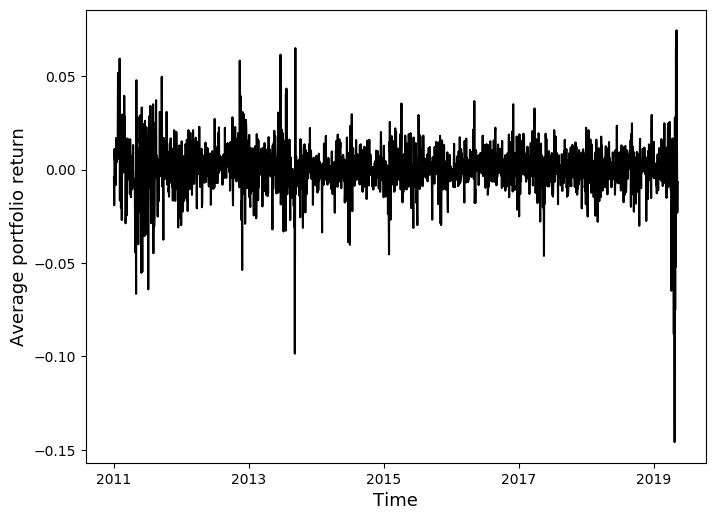

In [56]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(data["portfolio_return"], "k")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
plt.xlabel("Time", fontsize=13)
plt.ylabel("Average portfolio return", fontsize=13)

### 3. Plots

C:\Users\Asus\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


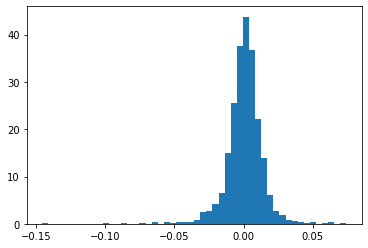

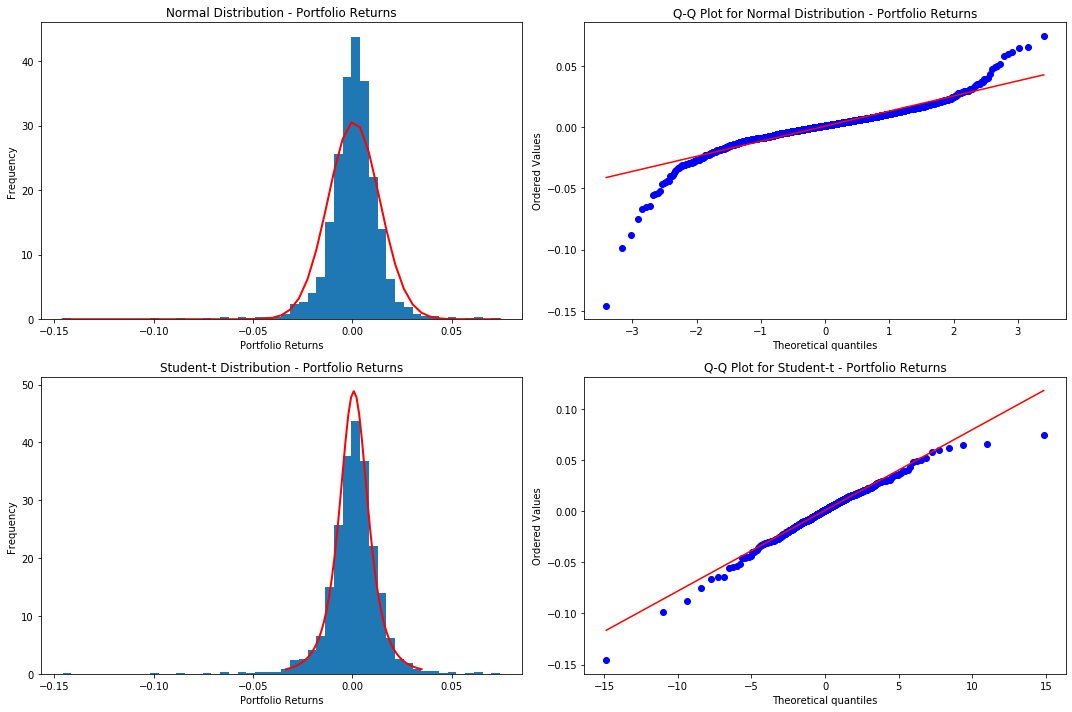

In [63]:
##assign df:
df = 3
# create distributions
mu = np.mean(data["portfolio_return"][1:])
sigma = np.std(data["portfolio_return"][1:])
sigmat = np.sqrt(np.var(data["portfolio_return"][1:]) * (df - 2) / df)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, normed=True)
normaldistr = (
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma ** 2))
)
tval = np.linspace(
    sc.stats.t.ppf(0.01, df, mu, sigmat), sc.stats.t.ppf(0.99, df, mu, sigmat), 51
)
tdistr = sc.stats.t.pdf(tval, df, mu, sigmat)  # Simulate t-distribution
### figure for t distr. and normal distr. comparison
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# normal
plt.subplot(2, 2, 1)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(bins, normaldistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Normal Distribution - Portfolio Returns")
# normal qq
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal Distribution - Portfolio Returns")
# stundent t
plt.subplot(2, 2, 3)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(tval, tdistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Student-t Distribution - Portfolio Returns")
# student t qq
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for Student-t - Portfolio Returns")
plt.tight_layout()
plt.show()

[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]


([<matplotlib.axis.XTick at 0x1a88f6e5448>,
 <a list of 5 Text xticklabel objects>)

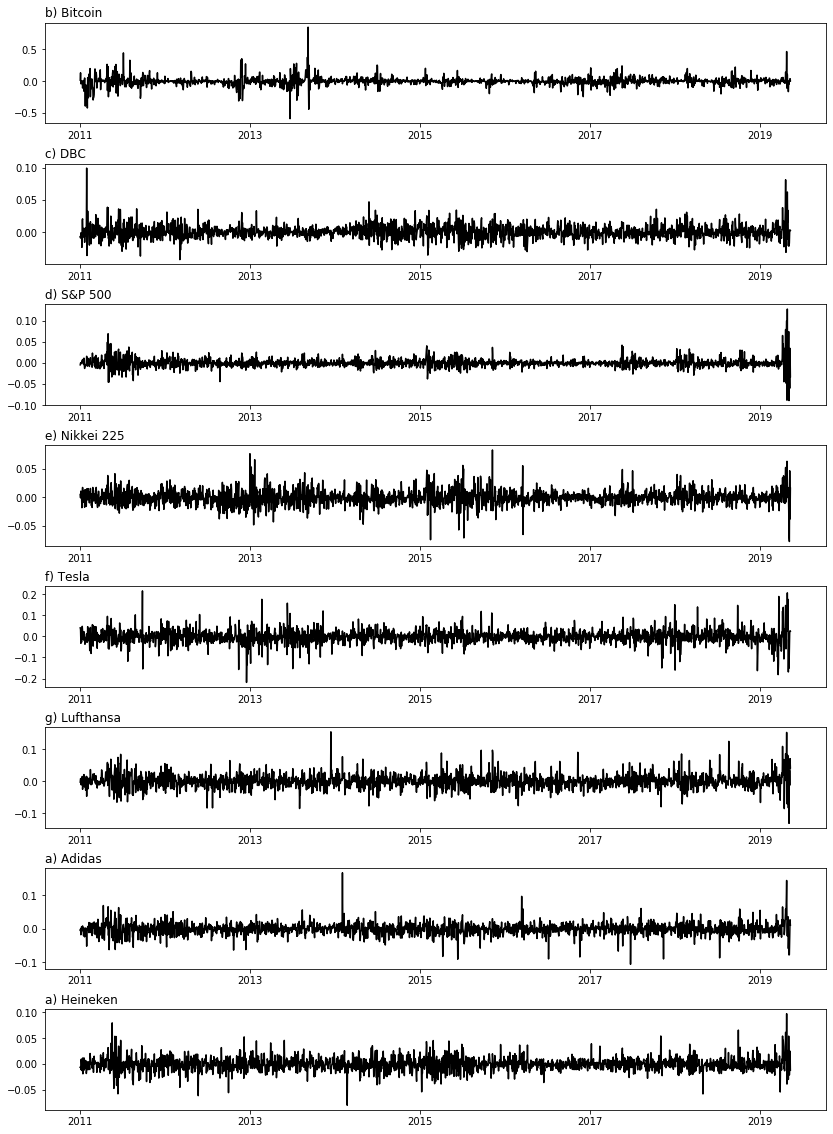

In [65]:
# plot of risk factor returns
"""I plot them as the negative of returns, so all are losses"""
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(14, 20))

# BTC_return
plt.subplot(8, 1, 1)
plt.plot(-data["BTC_return"][1:], "k")
plt.title("b) Bitcoin", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# DBC_return
plt.subplot(8, 1, 2)
plt.plot(-data["DBC_return"][1:], "k")
plt.title("c) DBC", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# GSPC_return
plt.subplot(8, 1, 3)
plt.plot(-data["GSPC_return"][1:], "k")
plt.title("d) S&P 500", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# N225_return
plt.subplot(8, 1, 4)
plt.plot(-data["N225_return"][1:], "k")
plt.title("e) Nikkei 225", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.subplots_adjust(hspace=0.4)
plt.xticks(locs[1:-1], new_xticks)
# TSLA_return
plt.subplot(8, 1, 5)
plt.plot(-data["TSLA_return"][1:], "k")
plt.title("f) Tesla", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.subplots_adjust(hspace=0.4)
plt.xticks(locs[1:-1], new_xticks)
# FX_YEN_return
plt.subplot(8, 1, 6)
plt.plot(-data["LHA_return"][1:], "k")
plt.title("g) Lufthansa", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.subplots_adjust(hspace=0.4)
plt.xticks(locs[1:-1], new_xticks)
# DE_1YBOND
plt.subplot(8, 1, 7)
plt.plot(-data["ADS_return"][1:], "k")
plt.title("a) Adidas", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# DE_1YBOND
plt.subplot(8, 1, 8)
plt.plot(-data["HEIA_return"][1:], "k")
plt.title("a) Heineken", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)

### Individual risk factor normality check

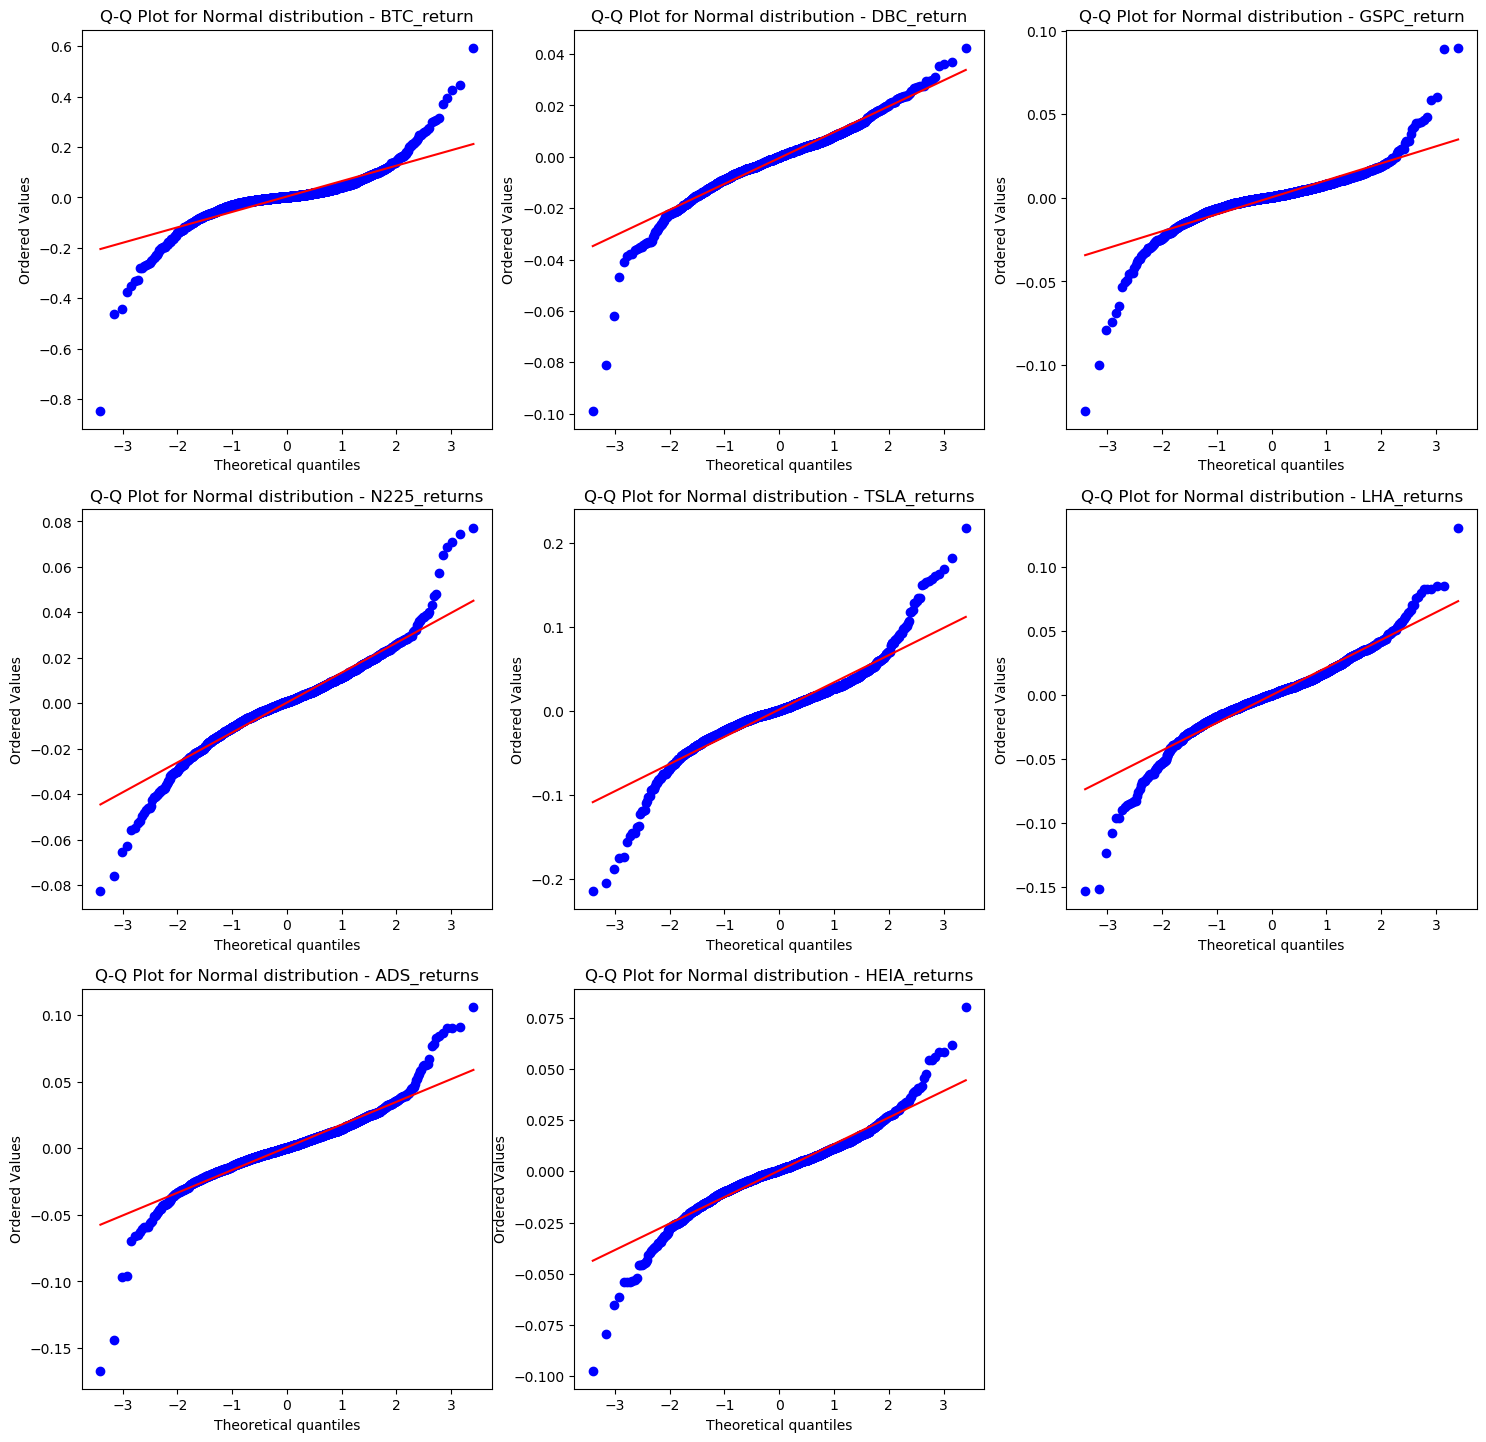

In [72]:
plt.figure(figsize=(18,18),dpi=100)
plt.subplot(3,3, 1)
sc.stats.probplot(data["BTC_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal distribution - BTC_return")
#plt.tight_layout()

plt.subplot(3,3, 2)
sc.stats.probplot(data["DBC_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal distribution - DBC_return")
#plt.tight_layout()

plt.subplot(3,3, 3)
sc.stats.probplot(data["GSPC_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal distribution - GSPC_return")
#plt.tight_layout()

plt.subplot(3,3, 4)
sc.stats.probplot(data["N225_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal distribution - N225_returns")
#plt.tight_layout()

plt.subplot(3,3, 5)
sc.stats.probplot(data["TSLA_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal distribution - TSLA_returns")
#plt.tight_layout()

plt.subplot(3,3, 6)
sc.stats.probplot(data["LHA_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal distribution - LHA_returns")
#plt.tight_layout()

plt.subplot(3,3, 7)
sc.stats.probplot(data["ADS_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal distribution - ADS_returns")
#plt.tight_layout()

plt.subplot(3,3, 8)
sc.stats.probplot(data["HEIA_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal distribution - HEIA_returns")
#plt.tight_layout()
plt.show()


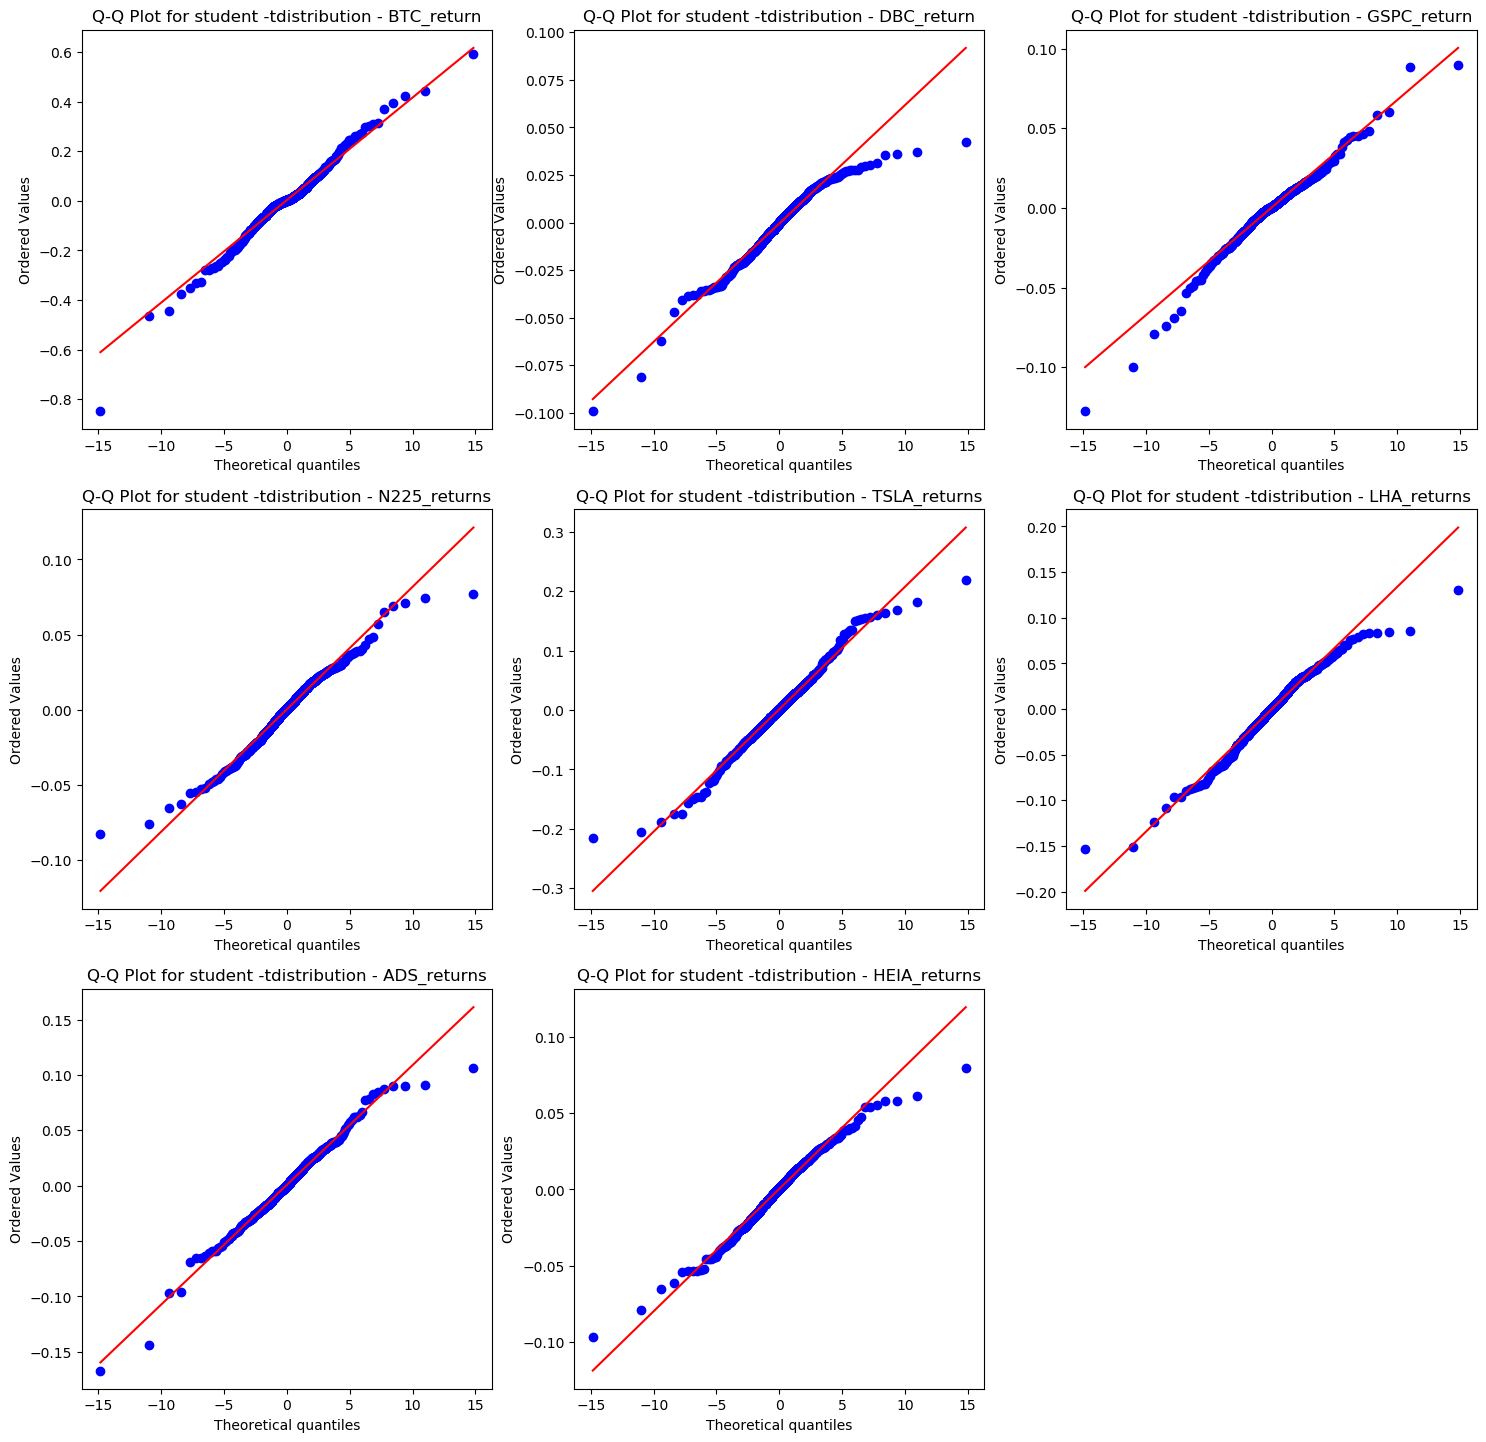

In [74]:
df = 3
plt.figure(figsize=(18,18),dpi=100)


plt.subplot(3,3, 1)
sc.stats.probplot(data["BTC_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for student -tdistribution - BTC_return")
#plt.tight_layout()

plt.subplot(3,3, 2)
sc.stats.probplot(data["DBC_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for student -tdistribution - DBC_return")
#plt.tight_layout()

plt.subplot(3,3, 3)
sc.stats.probplot(data["GSPC_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for student -tdistribution - GSPC_return")
#plt.tight_layout()

plt.subplot(3,3, 4)
sc.stats.probplot(data["N225_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for student -tdistribution - N225_returns")
#plt.tight_layout()

plt.subplot(3,3, 5)
sc.stats.probplot(data["TSLA_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for student -tdistribution - TSLA_returns")
#plt.tight_layout()

plt.subplot(3,3, 6)
sc.stats.probplot(data["LHA_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for student -tdistribution - LHA_returns")
#plt.tight_layout()


plt.subplot(3,3, 7)
sc.stats.probplot(data["ADS_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for student -tdistribution - ADS_returns")
#plt.tight_layout()

plt.subplot(3,3, 8)
sc.stats.probplot(data["HEIA_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for student -tdistribution - HEIA_returns")
#plt.tight_layout()
plt.show()



In [16]:
""" All eight risk factors and portfolio return"""
df_prices = data[
    [
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return",
        "TSLA_return",
        "LHA_return",
        "ADS_return",
        "HEIA_return",
        "portfolio_return",
    ]
]

In [17]:
"""Statistics on risk factor and total return (log of index change)"""
df_prices.describe()

,BTC_return,DBC_return,GSPC_return,N225_return,TSLA_return,LHA_return,ADS_return,HEIA_return,portfolio_return
count,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000
mean,0.003517,-0.000460,0.000316,0.000312,0.001363,-0.000183,0.000794,0.000384,0.000755
std,0.068724,0.010361,0.011176,0.013477,0.033914,0.022192,0.017780,0.013277,0.013026
min,-0.848765,-0.099117,-0.127652,-0.082529,-0.214772,-0.153021,-0.166886,-0.097219,-0.145822
25%,-0.015373,-0.005476,-0.003299,-0.006235,-0.014079,-0.010977,-0.008115,-0.006002,-0.005142
50%,0.002228,0.000000,0.000583,0.000672,0.000728,0.000309,0.000304,0.000644,0.001173
75%,0.023746,0.005147,0.005108,0.007600,0.017947,0.011087,0.009800,0.007458,0.007342
max,0.593371,0.042441,0.089683,0.077314,0.218292,0.130766,0.106011,0.080072,0.074455


In [18]:
df_prices.skew()

BTC_return         -0.687538
DBC_return         -0.953259
GSPC_return        -1.221200
N225_return        -0.246196
TSLA_return        -0.040635
LHA_return         -0.576335
ADS_return         -0.378314
HEIA_return        -0.400173
portfolio_return   -1.181644
dtype: float64

In [19]:
df_prices.kurtosis()

BTC_return          21.256266
DBC_return           7.219287
GSPC_return         20.443239
N225_return          4.273363
TSLA_return          6.683374
LHA_return           4.968616
ADS_return           9.362898
HEIA_return          4.870390
portfolio_return    13.806510
dtype: float64

In [20]:
len(df_prices)

2093

### Check student t-assumption with QQ-plots

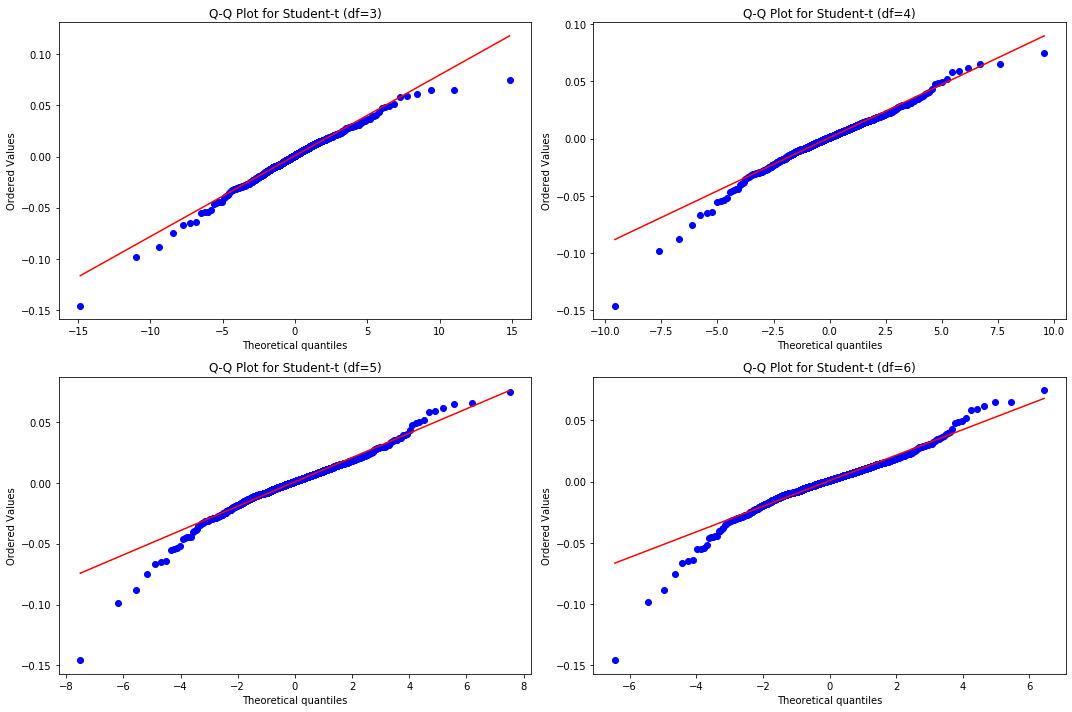

In [80]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplot(2, 2, 1)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(3), plot=plt)
plt.title("Q-Q Plot for Student-t (df=3)")
plt.tight_layout()
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(4), plot=plt)
plt.title("Q-Q Plot for Student-t (df=4)")
plt.tight_layout()
plt.subplot(2, 2, 3)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(5), plot=plt)
plt.title("Q-Q Plot for Student-t (df=5)")
plt.tight_layout()
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(6), plot=plt)
plt.title("Q-Q Plot for Student-t (df=6)")
plt.tight_layout()
plt.show()

### Check the correlation between assets

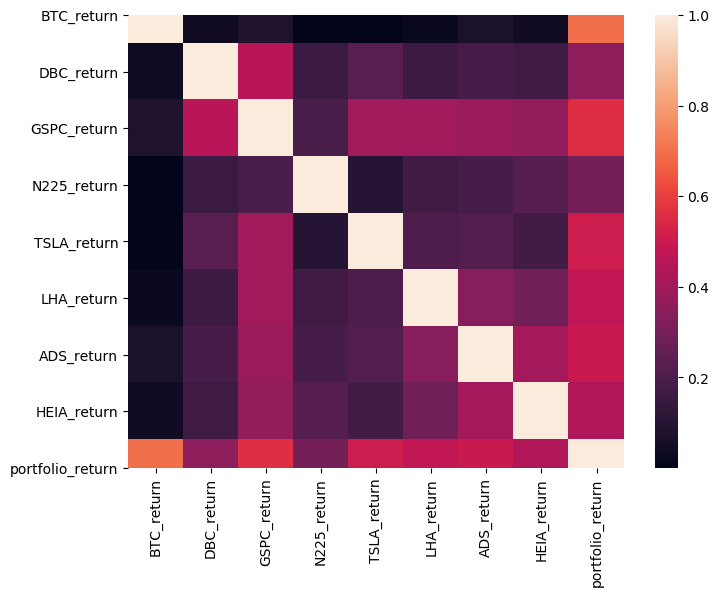

In [81]:
import seaborn as sns
plt.figure(figsize=(8,6),dpi=100)
corr = df_prices.corr()
sns.heatmap(corr)

### PCA

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df_prices.iloc[1:,:-1])

In [19]:
pca.explained_variance_ratio_

array([0.65002148, 0.17443435, 0.07573016, 0.03602527, 0.02361777])

Text(0.5, 0, 'Principle compenents')

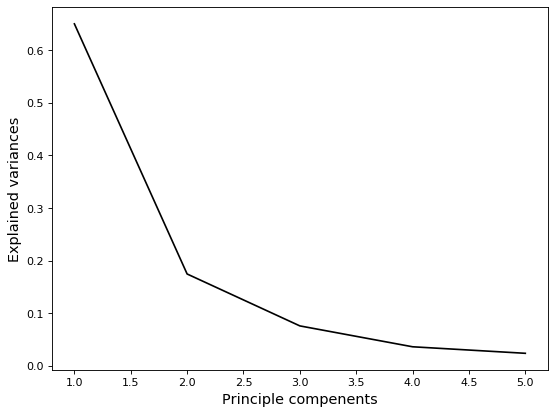

In [20]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot(np.arange(1,6,1),pca.explained_variance_ratio_,'k')
plt.ylabel('Explained variances',fontsize=13)
plt.xlabel('Principle compenents',fontsize=13)

In [39]:
cum = []
for i in range(1,6):
    add = pca.explained_variance_ratio_[0:i].sum()
    cum.append(add)

Text(0.5, 0, 'Principle compenents')

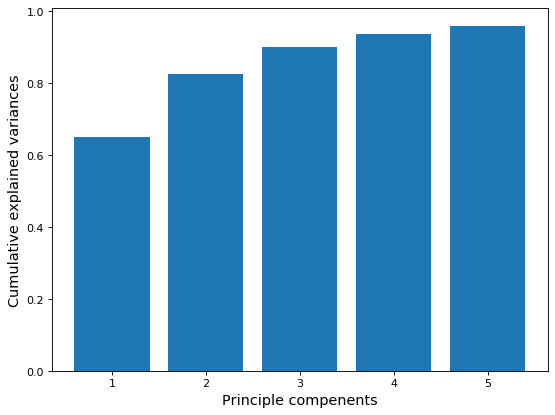

In [41]:
plt.figure(figsize=(8,6),dpi=80)
plt.bar(np.arange(1,6,1),cum)
plt.ylabel('Cumulative explained variances',fontsize=13)
plt.xlabel('Principle compenents',fontsize=13)

(-1.1, 0.2)

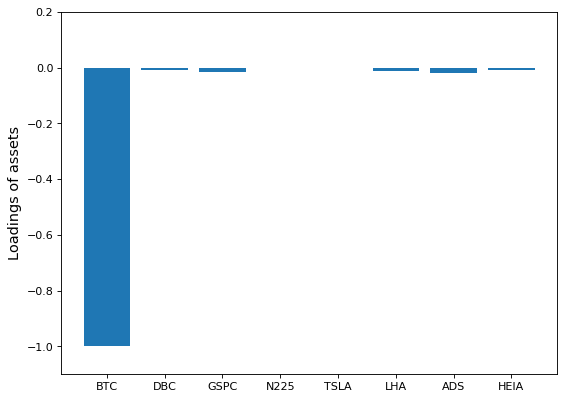

In [21]:
#The loading plot regarding the first principle component
plt.figure(figsize=(8,6),dpi=80)
x=np.arange(8)
plt.bar(x, pca.components_[0])
plt.xticks(x, ('BTC','DBC','GSPC','N225','TSLA','LHA','ADS','HEIA'))
plt.ylabel('Loadings of assets',fontsize=13)
plt.ylim((-1.1,0.2))

(-1.1, 0.2)

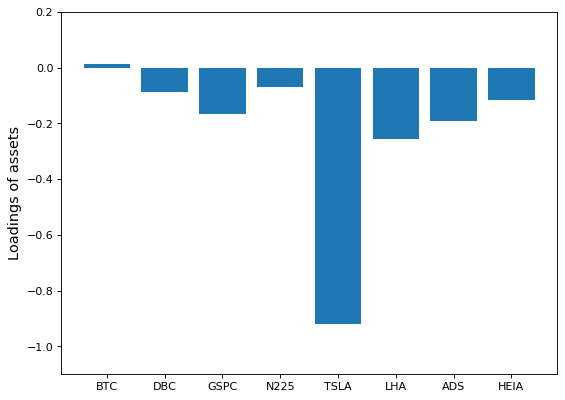

In [22]:
plt.figure(figsize=(8,6),dpi=80)
x=np.arange(8)
plt.bar(x, pca.components_[1])
plt.xticks(x, ('BTC','DBC','GSPC','N225','TSLA','LHA','ADS','HEIA'))
plt.ylabel('Loadings of assets',fontsize=13)
plt.ylim((-1.1,0.2))

In [23]:
df_prices = df_prices.set_index(pd.to_datetime(data["Date"]))

In [24]:
principalDf = pd.DataFrame(data = principalComponents[-750:]
             , columns = ['principal component 1', 'principal component 2','principal component 3',\
                         'principal component 4','principal component 5'])

In [26]:
date = []
for i in data['Date'].iloc[-750:]:
    date.append(i[:4])

In [27]:
date = pd.DataFrame(data=date,columns=['Date'])

In [28]:
date

,Date
0,2017
1,2017
2,2017
3,2017
4,2017
...,...
745,2020
746,2020
747,2020
748,2020


In [29]:
finalDf = pd.concat([principalDf,date], axis = 1)

In [30]:
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,Date
0,0.157821,-0.001035,-0.002722,-0.008495,0.001803,2017
1,-0.030572,0.005380,0.010133,-0.003327,-0.010371,2017
2,-0.020403,-0.033940,0.005871,-0.009208,0.001724,2017
3,-0.093479,0.008117,-0.014507,0.029319,-0.023446,2017
4,0.026663,-0.014300,-0.005279,-0.028397,-0.006782,2017


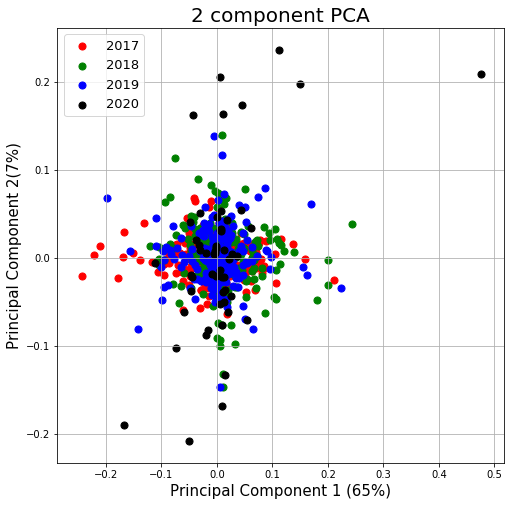

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 ({}%)'.format(str(pca.explained_variance_ratio_[0])[2:4]), fontsize = 15)
ax.set_ylabel('Principal Component 2({}%)'.format(str(pca.explained_variance_ratio_[1])[3]), fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['2017','2018','2019','2020']
colors = ['r', 'g', 'b','k']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Date'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)


ax.legend(('2017','2018','2019','2020'),fontsize=13)
ax.grid()


In [29]:
principalComponents

array([[ 0.01681853,  0.03452867, -0.02180367, -0.00561884, -0.00270476],
       [ 0.13313616,  0.02898317, -0.01132484, -0.0110239 ,  0.003594  ],
       [-0.04009072, -0.03054587,  0.0102836 , -0.0152167 , -0.01466865],
       ...,
       [-0.00310035,  0.00595177, -0.03022247, -0.00587975, -0.04082392],
       [ 0.04311908,  0.05453569,  0.05899865, -0.01940713,  0.04088531],
       [ 0.00812531,  0.03042637,  0.02045824, -0.02166708, -0.0025673 ]])